<a href="https://colab.research.google.com/github/tirthasheshpatel/Generative-Models/blob/gans/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
cd /content
FILES=`ls -a`
flag=0
for FILE in $FILES
do
    if [[ $FILE == "Generative-Models" ]]
    then
        cd $FILE
        branch=`git rev-parse --abbrev-ref HEAD`
        if [[ $branch == "gans" ]]
        then
            git pull origin $branch
        else
            git checkout gans
            git pull origin gans
        fi
        flag=1
        break
    fi
done

if [[ flag -ne 1 ]]
then
    git clone https://github.com/tirthasheshpatel/Generative-Models.git
    cd "Generative-Models"
    git checkout -b gans
    git pull origin gans
fi

From https://github.com/tirthasheshpatel/Generative-Models
 * branch            gans       -> FETCH_HEAD
Already up to date.


In [2]:
%env BATCH_SIZE=16
%env IMG_SIZE=256
%env LATENT_DIMS=100

env: BATCH_SIZE=16
env: IMG_SIZE=256
env: LATENT_DIMS=100


In [3]:
%cd /content/Generative-Models/
%tensorflow_version 1.x
import os
import functools
import tarfile

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
import cv2

from gan_utils import download_utils, tqdm_utils, keras_utils, loss_funcs, gan_discriminator, gan_generator, preprocess
%matplotlib inline
print(tf.__version__)
print(keras.__version__)
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

/content/Generative-Models
TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


In [4]:
download_utils.download_flowers_dataset("/content/Generative-Models/data")

**************************************************
102flowers.tgz
**************************************************
imagelabels.mat


In [0]:
x_train = preprocess.get_all_filenames("data/102flowers.tgz")
y_train = scipy.io.loadmat('data/imagelabels.mat')['labels'][0] - 1

In [6]:
gan_discriminator_model = gan_discriminator.GANDiscriminator()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [0]:
gan_discriminator_loss = loss_funcs.discriminator_loss

In [0]:
gan_generator_model = gan_generator.GANGenerator()

In [0]:
gan_generator_loss = loss_funcs.generator_loss

In [0]:
def sampling(shape):
    return K.random_normal(shape)
sampling = functools.partial(sampling, [int(os.getenv('BATCH_SIZE')), int(os.getenv('LATENT_DIMS'))])

In [0]:
sample = keras.layers.Lambda(lambda x: sampling())

In [0]:
x = keras.Input(batch_shape=[int(os.getenv('BATCH_SIZE')), int(os.getenv('IMG_SIZE')), int(os.getenv('IMG_SIZE')), 3])

In [13]:
true_labels = gan_discriminator_model(x)
sampled_z = sample(x)
gen_img = gan_generator_model(sampled_z)
gen_labels = gan_discriminator_model(gen_img)
disc_loss = gan_discriminator_loss(true_labels, gen_labels)
gen_loss = gan_generator_loss(gen_labels)

In [0]:
gan_discriminator_model = keras.engine.training.Model(x, true_labels)
gan_generator_model = keras.engine.training.Model(x, gen_img)

In [0]:
gan_discriminator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.0),
    loss=lambda *args, **kwargs: disc_loss
)

In [0]:
gan_generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.0),
    loss=lambda *args, **kwargs: gen_loss
)

In [0]:
discriminator_filename = 'gan_disc.{0:03d}'
generator_filename = 'gan_gen.{0:03d}'
last_finished_epoch = None

In [18]:
for _ in range(10):
    # gan_discriminator_model.fit_generator(
    #     preprocess.train_generator(x_train, y_train),
    #     steps_per_epoch=len(x_train) // int(os.getenv('BATCH_SIZE')) // 8,
    #     epochs = 1,
    #     # callbacks=[keras_utils.TqdmProgressCallback(),
    #     #         keras_utils.ModelSaveCallback(discriminator_filename.format(_) + '.{0:03d}.hdf5')],
    #     verbose=1,
    #     initial_epoch=last_finished_epoch or 0
    # )

    gan_generator_model.fit_generator(
        preprocess.train_generator(x_train, y_train),
        steps_per_epoch=len(x_train) // int(os.getenv('BATCH_SIZE')) // 16,
        epochs = 1,
        # callbacks=[keras_utils.TqdmProgressCallback(),
        #         keras_utils.ModelSaveCallback(generator_filename.format(_) + '.{0:03d}.hdf5')],
        verbose=1,
        initial_epoch=last_finished_epoch or 0
    )


Epoch 1/1
31/31 [==============================] - 19s 617ms/step - loss: 0.8335
Epoch 1/1
31/31 [==============================] - 15s 480ms/step - loss: 0.8246
Epoch 1/1
31/31 [==============================] - 15s 481ms/step - loss: 0.8229
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8283
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8281
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8279
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8263
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8257
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8251
Epoch 1/1
31/31 [==============================] - 15s 482ms/step - loss: 0.8236


In [0]:
generated_images = sess.run(gen_img, feed_dict={x: np.random.randn(16, 256, 256, 3)})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


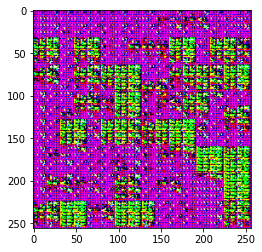

In [20]:
plt.imshow(generated_images[9])

In [0]:
labels = sess.run(gen_labels, feed_dict={x: generated_images})

In [22]:
labels

array([[0.56052655],
       [0.6006173 ],
       [0.50916624],
       [0.49582526],
       [0.5532681 ],
       [0.53819317],
       [0.53938794],
       [0.5353331 ],
       [0.42461392],
       [0.57244194],
       [0.51660633],
       [0.57414997],
       [0.55141914],
       [0.59950244],
       [0.5620084 ],
       [0.47465888]], dtype=float32)